In [1]:
using DrWatson
@quickactivate "TriangularHubbard"

using TriangularHubbard
using PyPlot
using JSON
using LinearAlgebra

using DBInterface
using SQLite
using DataFrames

  Activating project at `/data/pn1_1/klee/Projects/TriangularHubbard`
┌ Info: Precompiling TriangularHubbard [764e0693-ed7c-5b1b-ba3b-45c24a360dd6]
└ @ Base loading.jl:1423


In [22]:
shape_str = "(2,-2)x(2,4)"
# shape_str = "(3,0)x(0,3)"
sectors_filepath = datadir("curie", shape_str, "sectors.sqlite3")
t = 1.0
U = 20.0

20.0

In [4]:
jsondata = open(datadir("lattice-$shape_str.json"), "r") do f
    JSON.parse(read(f, String))
end

Dict{String, Any} with 7 entries:
  "shape"                 => Any[Any[2, -2], Any[2, 4]]
  "momentums"             => Any[Dict{String, Any}("fractional_coordinates"=>An…
  "point_group_symmetry"  => "6mm"
  "supercell"             => Dict{String, Any}("sites"=>Any[Dict{String, Any}("…
  "equivalent_site_pairs" => Any[Any[Any[1, 1], Any[2, 2], Any[3, 3], Any[4, 4]…
  "unitcell"              => Dict{String, Any}("sites"=>Any[Dict{String, Any}("…
  "bravais_coordinates"   => Any[Any[0, 0], Any[1, 0], Any[2, 0], Any[1, 2], An…

In [5]:
shape = hcat(jsondata["shape"]...)
n_sites = Int(det(shape))
bravaiscoordinates = hcat(jsondata["bravais_coordinates"]...)
sitecoordinates = hcat((x["cartesian_coordinates"] for x in jsondata["supercell"]["sites"])...)
momentums = hcat((x["cartesian_coordinates"] for x in jsondata["momentums"])...)
fractionalmomentums = hcat(([eval(Meta.parse(y)) for y in x["fractional_coordinates"]] for x in jsondata["momentums"])...)
sitegroupmap = Dict()
for (i, vs) in enumerate(jsondata["equivalent_site_pairs"])
    for v in vs
        sitegroupmap[v] = i
    end
end


In [7]:
function getrealspacemap(data::AbstractVector)
    realspacemap = fill(NaN, (n_sites, 1))
    for i in 1:n_sites
        realspacemap[i] = data[sitegroupmap[[1,i]]]
    end
    return realspacemap
end

getrealspacemap (generic function with 1 method)

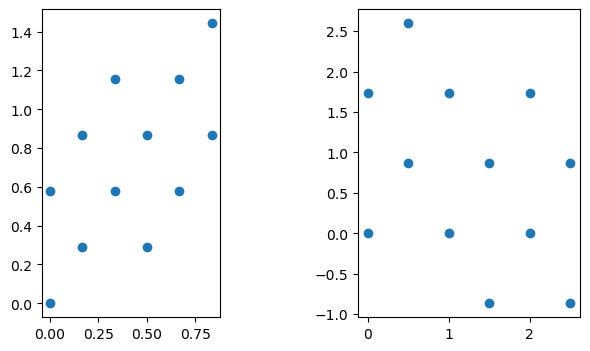

In [15]:
# Plot sites and momenta
fig = PyPlot.figure(figsize=(8,4))
ax = fig.add_subplot(1,2,1)
ax.plot(momentums[1,:], momentums[2,:], "o")
ax.set_aspect(1.0)
ax = fig.add_subplot(1,2,2)
ax.plot(sitecoordinates[1,:], sitecoordinates[2,:], "o")
ax.set_aspect(1.0)

In [16]:
raw"""
$$
\tilde{f}(q_i) = \sum_{j} e^{-i q_i x_j} f(x_j)
= [e^{-i Q^T X} f]_i
$$
"""

"\$\$\n\\tilde{f}(q_i) = \\sum_{j} e^{-i q_i x_j} f(x_j)\n= [e^{-i Q^T X} f]_i\n\$\$\n"

In [17]:
phases = cis.(-2π * momentums' * sitecoordinates)
# phases2 = cis.(-2π * fractionalmomentums' * bravaiscoordinates)
# realspacemap_test = rand(Float64, (n_sites, 1))
realspacemap_test = ones(Float64, (n_sites, 1))
abs2.(phases * realspacemap_test)

12×1 Matrix{Float64}:
 144.0
   3.463592411986005e-30
   1.2288973789146075e-29
   0.0
   4.7639803104362666e-29
   2.2581143411951463e-29
   1.2561059819587193e-29
   4.44966854351227e-30
   1.858753507927009e-29
   4.6132260218078836e-30
   6.7053176943786e-30
   2.3982604113883167e-28

"/data/pn1_1/klee/Projects/TriangularHubbard/data/curie/(2,-2)x(2,4)/sectors.sqlite3"

In [23]:
conn = DBInterface.connect(SQLite.DB, sectors_filepath)
df1 = DataFrame(
    DBInterface.execute(conn, """
        SELECT nup, ndn, dim, temperature, partition, spin_correlation, energy, energy_squared, 0 as sparsetype
        FROM dense_results
        INNER JOIN sectors
        ON dense_results.idx = sectors.idx
        WHERE hopping=? AND interaction=?
    """, (t, U))
)
df2 = DataFrame(
    DBInterface.execute(conn, """
        SELECT nup, ndn, dim, temperature, partition, spin_correlation, energy, energy_squared, 1 as sparsetype
        FROM sparse_results_collection
        INNER JOIN sectors
        ON sparse_results_collection.idx = sectors.idx
        WHERE hopping=? AND interaction=?
    """, (t, U))
)
DBInterface.close!(conn)

In [24]:
for s in df[!, :spin_correlation]
    m = getrealspacemap(JSON.parse(s))
    break
end

LoadError: UndefVarError: df not defined